In [1]:
import torch
from torch import nn
import torch.utils.data as Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from preprocessing import StandardScaler, Split
from model import Regressor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
epochs = 200
batch_size = 512
best_model = np.inf
timesteps = 90
target = 0

In [3]:
df = pd.read_csv('bdi.csv')
df.fillna(method='ffill', inplace=True)
data = df['bdi'].values

In [4]:
x = []
y = []
for i in range(timesteps, data.shape[0] - target):
    x.append(data[i-timesteps:i])
    y.append(data[i + target])
x = np.array(x).reshape(-1, 6, 1, 15)
y = np.array(y).reshape(-1, 1)

In [5]:
x_train, y_train, x_val, y_val, x_test, y_test = Split(x, y)

In [6]:
scaler = StandardScaler(y_train)
x_train = scaler.transform(x_train)
y_train = scaler.transform(y_train)
x_val = scaler.transform(x_val)
y_val = scaler.transform(y_val)
x_test = scaler.transform(x_test)

In [7]:
x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
x_val = torch.FloatTensor(x_val).to(device)
y_val = torch.FloatTensor(y_val).to(device)
x_test = torch.FloatTensor(x_test).to(device)

In [8]:
dataset = Data.TensorDataset(x_train, y_train)
dataloader = Data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

In [9]:
model = Regressor().to(device)
print(model)

Regressor(
  (cnn): Conv1d(1, 32, kernel_size=(2,), stride=(1,), padding=(2,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ft): Flatten(start_dim=2, end_dim=-1)
  (lstm): LSTM(288, 32, num_layers=2, batch_first=True)
  (sequential): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [11]:
history = dict()
history['loss'] = []
history['val_loss'] = []
filepath = 'checkpoint.pt'
for epoch in range(epochs):
    if epoch == 150:
        model = torch.load(filepath)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    for x_batch, y_batch in dataloader:
        model.train()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    with torch.no_grad():
        model.eval()
        y_pred = model(x_val)
        val_loss = criterion(y_pred, y_val)
    print(f'epoch:{epoch + 1:03d}-loss:{loss.item():.5f}-val_loss:{val_loss.item():.5f}')
    history['loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())
    if val_loss.item() <= best_model:
        best_model = val_loss
        torch.save(model, filepath)
        print('weight saved')
model = torch.load(filepath)

epoch:001-loss:0.08881-val_loss:0.01368
weight saved
epoch:002-loss:0.02027-val_loss:0.00296
weight saved
epoch:003-loss:0.00829-val_loss:0.00157
weight saved
epoch:004-loss:0.00421-val_loss:0.00169
epoch:005-loss:0.00458-val_loss:0.00123
weight saved
epoch:006-loss:0.00245-val_loss:0.00102
weight saved
epoch:007-loss:0.00183-val_loss:0.00117
epoch:008-loss:0.00284-val_loss:0.00056
weight saved
epoch:009-loss:0.00490-val_loss:0.00051
weight saved
epoch:010-loss:0.00213-val_loss:0.00045
weight saved
epoch:011-loss:0.00279-val_loss:0.00053
epoch:012-loss:0.00204-val_loss:0.00054
epoch:013-loss:0.00108-val_loss:0.00044
weight saved
epoch:014-loss:0.00206-val_loss:0.00055
epoch:015-loss:0.00225-val_loss:0.00111
epoch:016-loss:0.00116-val_loss:0.00052
epoch:017-loss:0.00109-val_loss:0.00060
epoch:018-loss:0.00153-val_loss:0.00115
epoch:019-loss:0.00302-val_loss:0.00107
epoch:020-loss:0.00234-val_loss:0.00035
weight saved
epoch:021-loss:0.00255-val_loss:0.00065
epoch:022-loss:0.00100-val_los

epoch:199-loss:0.00043-val_loss:0.00012
epoch:200-loss:0.00031-val_loss:0.00012


In [12]:
model.eval()
with torch.no_grad():
    predict = model(x_test).cpu().numpy()
    predict = scaler.inverse_transform(predict)

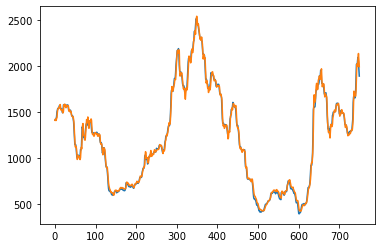

25.354443684895834


In [13]:
plt.plot(y_test)
plt.plot(predict)
plt.show()
print(metrics.mean_absolute_error(predict, y_test))

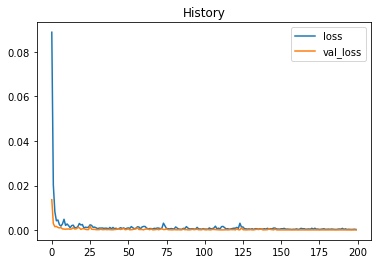

In [14]:
plt.plot(history['loss'], label='loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('History')
plt.legend()
plt.show()